# Predicting Customer Churn
### Analysis Performed by cjohn033
### Customer: Cell2Cell

## Purpose:

Walkthrough the process of using analytics to *determine the variables driving churn and propose a focused customer retention plan to mitigate churn.*

### Defining the Problem and Data Understanding

As customer growth has plateaued of the last more than a decade us the telecommunications industry, attempts to keep current subscribers has become a focus for marketing teams. The power of proactively identifying customers who are more likey to churn allows marketers to pinpoint target regions, demographics, etc. to deliver more customized and resource-friendly retention solutions. This following analysis is a best-effort to construct a viable model for predicting churn as a basis for a generalized retention plan.

#### The Data
The initial data set contains 70 fields that have potential value to the analysis. Not all will be used to create an optimal model, and some records contain insufficient data or missing values and will be dealt with in an appropriate manner.

In [2]:
# Supress warnings
oldw <- getOption("warn")
options(warn = -1)

# Package dependencies:
#install.packages("dplyr")
#install.packages("tidyr")
#install.packages("ggplot2")                
#install.packages("corrplot")
                 
#install.packages("dplyr", repos = 'https://cran.cnr.berkeley.edu/')
#install.packages("tidyr", repos = 'https://cran.cnr.berkeley.edu/')
#install.packages("ggplot2", repos = 'https://cran.cnr.berkeley.edu/')
#install.packages("corrplot", repos = 'https://cran.cnr.berkeley.edu/')

In [3]:
# Libraries
library(dplyr)
library(tidyr)
library(ggplot2)
library(corrplot)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

corrplot 0.84 loaded


In [4]:
dt <- read.csv("cell2cell-v1.csv", as.is = TRUE)

In [5]:
# Remove one hot encoded variables
one_hot <- function(x) {  
  ch <- c(0,1,NA)  
  if (x %in% ch)y = 0 else y = 1  
  return(y)
}

### Data Pre-processing

In [6]:
# Separate the Training set into a data frame
train_dt <- dt %>% filter(traintest == 1) %>%
  select(-X.1,-X, -customer,-traintest)

In [ ]:
# Checking for NAs that will be dealt with later
## Remove for final analysis
train_dt %>% 
  summarise_all(funs(sum(is.na(.)))) %>%
  gather(var, na_count) %>%
  filter(na_count > 0)

In [7]:
head(train_dt[train_dt$churn == 1,], 15)

,churn,churndep,revenue,mou,recchrge,directas,overage,roam,changem,changer,...,retaccpt,newcelly,newcelln,refer,incmiss,income,mcycle,setprcm,setprc,retcall
20001,1,1,23.9975,219.25,22.50,0.2475,0.00,0.0000,-157.25,-18.9975,...,0,0,0,0,0,4,0,0,29.989990,1
20002,1,1,16.9900,10.25,16.99,0.0000,0.00,0.0000,-4.25,0.0000,...,0,1,0,0,0,5,0,0,29.989990,0
20003,1,1,17.1450,0.00,16.99,0.0000,0.00,0.0000,0.00,-0.1550,...,0,0,1,0,0,9,0,0,9.989998,0
20004,1,1,172.4400,1978.00,99.99,0.0000,362.25,0.0000,-1007.00,-72.4500,...,0,0,0,0,0,6,0,0,149.989990,1
20005,1,1,60.1850,1424.50,56.25,0.2475,0.00,0.0000,-1134.50,-55.1850,...,0,0,0,0,0,5,0,0,129.989990,1
20006,1,1,24.4900,41.75,16.99,0.0000,9.50,0.0000,81.25,29.9300,...,0,0,1,0,0,9,0,0,29.989990,0
20007,1,1,33.4775,195.50,29.99,0.0000,0.25,2.5650,54.50,8.5725,...,0,1,0,0,0,9,0,0,29.989990,0
20008,1,1,16.1400,3.75,16.99,0.0000,0.00,0.0000,-3.75,0.0000,...,0,1,0,0,0,6,0,1,0.000000,0
20009,1,1,57.9800,683.75,54.98,0.0000,3.00,0.0000,-1.75,0.6000,...,0,0,1,0,0,9,0,0,29.989990,0
20010,1,1,78.2875,851.50,85.00,0.0000,0.00,0.0000,-205.50,-0.0375,...,0,0,1,0,0,5,0,0,9.989998,0


In [8]:
# Check the data for one hot encoded variables and remove them
train_dt %>% select(-churn, -churndep) %>%
  summarise_all(funs(chk = sum(one_hot(.)))) %>%
  gather(var, val) %>% 
  filter(val != 0) %>%
  mutate(var = substr(var,1,nchar(var) - 4)) %>%
  pull(var)-> reg_variables

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


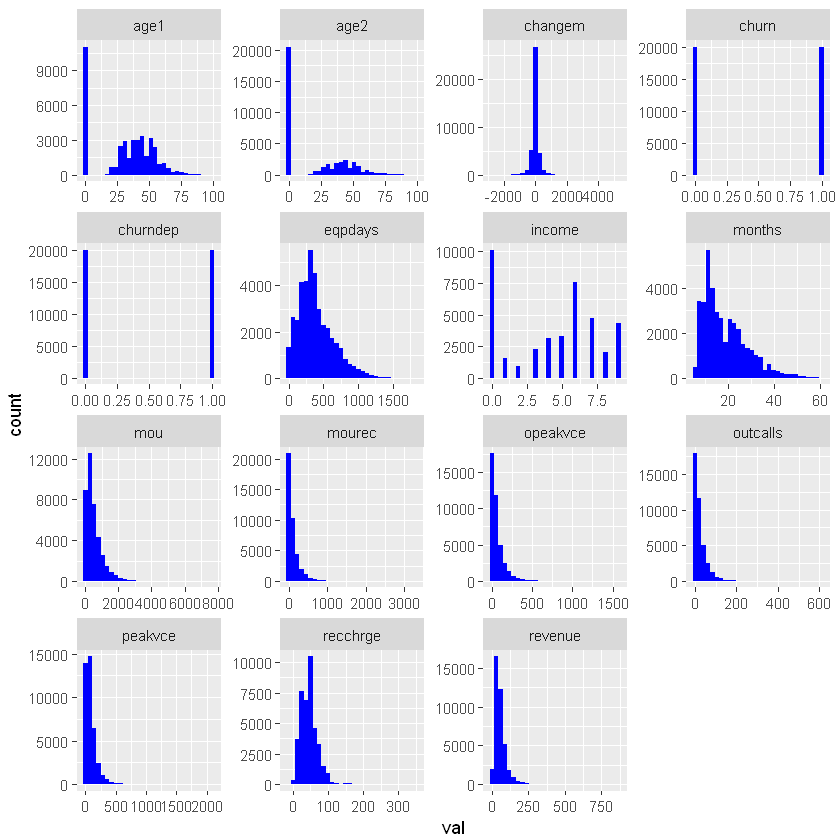

In [14]:
# Check the remainnig variables
train_dt %>% 
  select(reg_variables, churn, churndep)  %>%
  gather(var,val) %>%
  ggplot(aes(x = val)) +
  geom_histogram(fill = "blue") +
  facet_wrap(~ var, scales = "free")

In [12]:
reg_variables

[1] "revenue"  "mou"      "recchrge" "changem"  "mourec"   "outcalls"
 [7] "peakvce"  "opeakvce" "months"   "eqpdays"  "age1"     "age2"    
[13] "income"

In [ ]:
# Fill Training set with appropriate variables for model
#train_dt <- train_dt %>% 
 # select(reg_variables, churn, churndep)

In [15]:
# Create correlations and p-values for all variables in model
train_dt %>% mutate_all(funs(as.numeric)) %>%
  summarise_all(funs(cor_val = cor.test(., train_dt$churn)$estimate,
                     p_val = cor.test(., train_dt$churn)$p.value)) %>% 
  select(-contains("churn")) %>%
  gather(variable, val) %>%
  mutate(org_var = ifelse((regexpr("cor_val",variable)>0), 
                          gsub("_cor_val", "", variable),
                          gsub("_p_val", "", variable)),
        s_variable = ifelse((regexpr("cor_val",variable)>0), 
                          "cor_val","p_val")) %>% 
  select(-variable) %>% 
  spread(s_variable, val) %>%
  arrange(desc(abs(cor_val))) -> train_stat

In [16]:
# Remove all variables with significance less than 0.02
# Note: Null hypothesis true correlation = 0
train_stat %>% filter(p_val < 0.02) -> train_stat

In [17]:
head(train_dt,15)


churn,churndep,revenue,mou,recchrge,directas,overage,roam,changem,changer,...,retaccpt,newcelly,newcelln,refer,incmiss,income,mcycle,setprcm,setprc,retcall
0,0,38.0000,7.50,38.000,0.0000,0.00,0.0000,-1.50,0.0000,...,0,1,0,0,0,6,0,1,0.000000,0
0,0,55.2300,570.50,71.980,0.0000,0.00,0.0000,38.50,0.0000,...,0,1,0,0,0,6,0,0,79.989990,0
0,0,38.0525,682.50,52.490,0.2475,0.00,0.0000,147.50,-3.0625,...,0,1,0,0,0,1,0,0,29.989990,0
0,0,97.3375,1039.00,50.000,4.9500,419.50,0.0000,198.00,23.2625,...,0,1,0,0,0,4,0,0,9.989998,0
0,0,35.2950,24.25,34.980,0.0000,0.00,0.0000,19.75,-0.3150,...,0,1,0,0,0,9,0,0,79.989990,0
0,0,81.0000,1056.25,75.000,0.0000,0.00,0.0000,42.75,2.3500,...,0,1,0,0,0,5,0,0,29.989990,0
0,0,63.0175,440.25,59.980,0.0000,5.75,1.3125,-16.25,0.2125,...,0,0,1,0,0,3,0,0,29.989990,0
0,0,29.9900,47.00,29.990,0.0000,0.00,0.0000,14.00,0.0000,...,0,1,0,0,0,9,0,0,29.989990,0
0,0,21.1500,45.50,16.990,0.0000,14.00,0.0000,-15.50,-4.1600,...,0,1,0,0,0,7,0,0,29.989990,0
0,0,30.0000,155.75,30.000,0.0000,0.00,0.0000,94.25,0.0000,...,0,1,0,0,0,9,0,0,149.989990,0


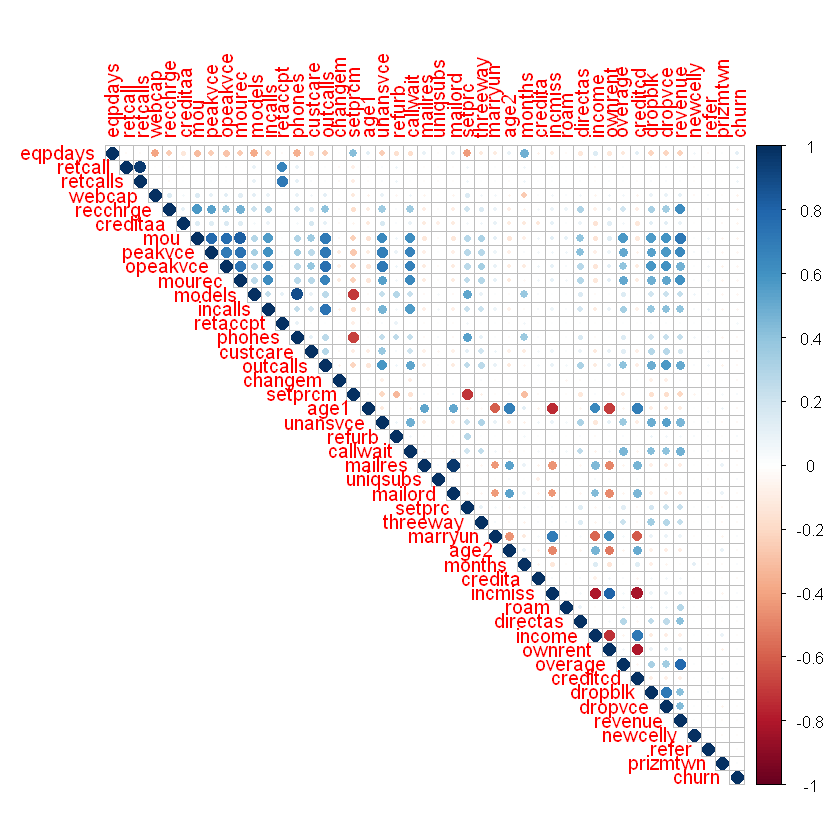

In [18]:
# Remove highly correlated values variables
train_dt %>% select(train_stat$org_var, churn) %>%
  cor(use = "pairwise.complete.obs") -> correl

corrplot(correl, method = "circle", type = "upper")

# Turn warnings back on
options(warn = oldw)

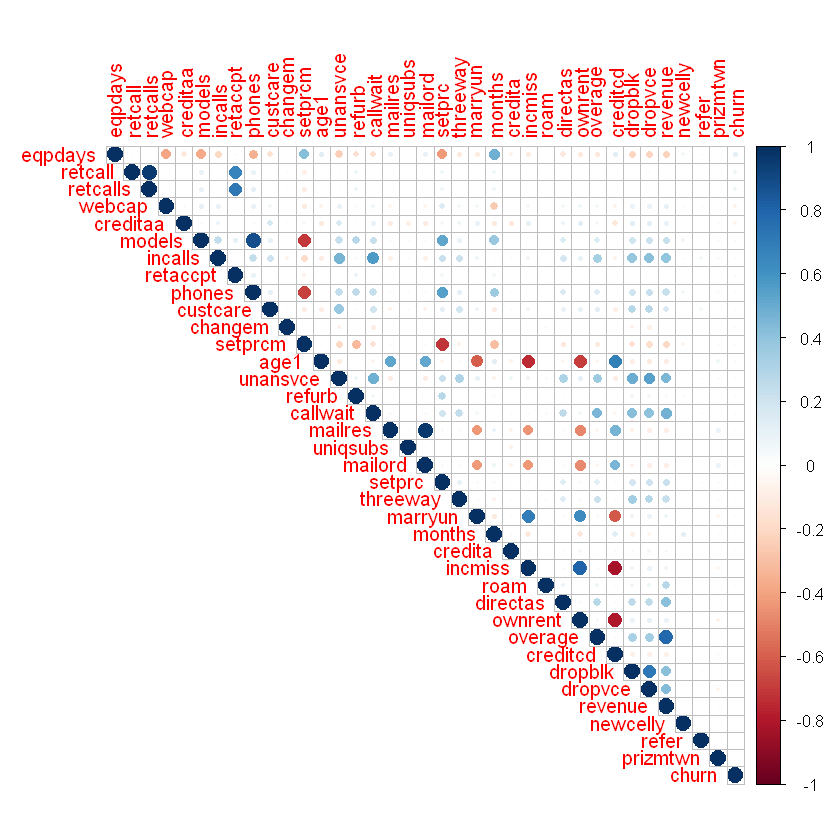

In [23]:
# Using data dictionary, the following variables are excluded:
# for revenue = recchrge, mou, peakvce, opeakvce, mourec, incalls
#               outcalls
# for age1 = age2, income

# Subset Training variables
train_dt %>% select(train_stat$org_var, churn) %>%
    select(-recchrge, -mou, -peakvce, -opeakvce, -mourec, 
         -outcalls, -age2, -income) %>%  
    #cor(train_dt, use = "everything",
     #   method = c("pearson", "kendall", "spearman")) > .75 %>%
    #cor(train_dt, use = "everything",
     #   method = c("pearson", "kendall", "spearman")) < '-.75' -> correl_new
  cor(use = "pairwise.complete.obs") -> correl_new

corrplot(correl_new, method = "circle", type = "upper")

train_dt %>% select(train_stat$org_var, churn) %>%
  select(-recchrge, -mou, -peakvce, -opeakvce, -mourec, 
         -outcalls, -age2, -income) -> train_dt

In [39]:
# Check Training variables
sapply(train_dt, summary)
sapply(train_dt, class)


$eqpdays
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   -5.0   212.0   342.0   392.8   532.0  1823.0 

$retcall
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.04043 0.00000 1.00000 

$retcalls
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.04403 0.00000 4.00000 

$webcap
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  1.0000  1.0000  0.8949  1.0000  1.0000 

$creditaa
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.1182  0.0000  1.0000 

$models
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.543   2.000  14.000 

$incalls
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   2.000   7.994   8.667 519.333 

$retaccpt
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.02042 0.00000 4.00000 

$phones
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.788   2.000  24.000 

$custcare
   Min. 1st Qu.  M

eqpdays   retcall  retcalls    webcap  creditaa    models   incalls  retaccpt 
"integer" "integer" "integer" "integer" "integer" "integer" "numeric" "integer" 
   phones  custcare   changem   setprcm      age1  unansvce    refurb  callwait 
"integer" "numeric" "numeric" "integer" "integer" "numeric" "integer" "numeric" 
  mailres  uniqsubs   mailord    setprc  threeway   marryun    months   credita 
"integer" "integer" "integer" "numeric" "numeric" "integer" "integer" "integer" 
  incmiss      roam  directas   ownrent   overage  creditcd   dropblk   dropvce 
"integer" "numeric" "numeric" "integer" "numeric" "integer" "numeric" "numeric" 
  revenue  newcelly     refer  prizmtwn     churn 
"numeric" "integer" "integer" "integer" "integer"

In [40]:
# Normalize data using transformations
normalize <- function(x) {
  (x - min(x[!is.na(x)]))/(max(x[!is.na(x)]) - min(x[!is.na(x)]))
}

train_dt %>% mutate(months = normalize(months),
                    revenue = normalize(revenue),
                    changem = normalize(changem),
                    revenue = normalize(revenue)) %>%
  mutate(tot = rowSums(.)) %>%
  filter(!is.infinite(tot)) %>%
  select(-tot) -> train_dt

### Fitting A Classifier to the Training Set
#### Applying K-Folds Cross Validation (Not yet applied)

In [41]:
# Fit a logistic regression model
model <- glm(churn~., data = train_dt, family = binomial)
model
anova(model)


Call:  glm(formula = churn ~ ., family = binomial, data = train_dt)

Coefficients:
(Intercept)      eqpdays      retcall     retcalls       webcap     creditaa  
  0.7049807    0.0014668    0.8281684    0.0109093   -0.1824649   -0.3446298  
     models      incalls     retaccpt       phones     custcare      changem  
  0.0125020   -0.0042074   -0.1355375    0.0429204   -0.0082958   -2.3356123  
    setprcm         age1     unansvce       refurb     callwait      mailres  
 -0.1097409   -0.0035846    0.0000235    0.2386648   -0.0066187   -0.1273086  
   uniqsubs      mailord       setprc     threeway      marryun       months  
  0.0733551    0.0137563    0.0005428   -0.0313176    0.0691148   -1.1838645  
    credita      incmiss         roam     directas      ownrent      overage  
 -0.1571259   -0.0369973    0.0097600   -0.0075033    0.0110099    0.0015114  
   creditcd      dropblk      dropvce      revenue     newcelly        refer  
  0.0301848    0.0023044    0.0029724   -1.4900

,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,38940,53983.15
eqpdays,1,4.912847e+02,38939,53491.86
retcall,1,2.029532e+02,38938,53288.91
retcalls,1,1.093896e-01,38937,53288.80
webcap,1,2.525587e+01,38936,53263.55
creditaa,1,8.239482e+01,38935,53181.15
models,1,3.452160e+00,38934,53177.70
incalls,1,8.754080e+00,38933,53168.94
retaccpt,1,1.584184e+00,38932,53167.36
phones,1,1.358024e+00,38931,53166.00


In [42]:
# Training the classification model
pred_train_dt <- predict(model,train_dt, type = "response")

dt %>% filter(traintest == 0) %>%
  select(train_stat$org_var, churn) %>%
  select(train_stat$org_var, churn) %>%
  select(-recchrge, -mou, -peakvce, -opeakvce, -mourec, 
         -outcalls, -age2, -income) %>% 
  mutate(months = normalize(months),
         revenue = normalize(revenue),
         changem = normalize(changem),
         revenue = normalize(revenue)) -> test_dt

### Prediciting the Test Set Results


In [43]:
# Predicting the Test data
pred_test_dt <- predict(model,test_dt, type = "response")

### Evaluating the Model
#### Confusion Matrix
#### Chi Squared Test for Independence
#### ROC or CAP Analysis


In [44]:
# Create the Confusion Matrix
test_dt <- cbind(test_dt, pred_test_dt)

In [45]:
# True positive
tp <- test_dt %>% 
  filter(churn == 1) %>%
  filter(pred_test_dt > 0.5) %>% 
  summarise(count = n()) %>%
  pull(count)
  
# True negative
tn <- test_dt %>% 
  filter(churn == 0) %>%
  filter(pred_test_dt <= 0.5) %>% 
  summarise(count = n()) %>%
  pull(count)

# False positive
fp <- test_dt %>% 
  filter(churn == 0) %>%
  filter(pred_test_dt > 0.5) %>% 
  summarise(count = n()) %>%
  pull(count)

# False negative
fn <- test_dt %>% 
  filter(churn == 1) %>%
  filter(pred_test_dt <= 0.5) %>% 
  summarise(count = n()) %>%
  pull(count)

### Results and Retention Plan

In [46]:
# Accuracy of model based on Confusion Matrix
accuracy <- (tp + tn)/(tp + tn + fp + fn)*100
accuracy

[1] 85.85353